In [1]:
import keras.callbacks
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import Dropout
%matplotlib inline
import tensorflow as tf
import warnings

warnings.filterwarnings('ignore')
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from keras import layers, models

In [2]:
def prepareData():
    allData = pd.read_csv("data/songs_with_genre.csv", index_col=0,header=[0, 1, 2])
    genres = allData["genre_id"]
    genres_index = pd.read_csv("data/genres_no_zeroes.csv", index_col=0)
    genres.columns = range(genres.shape[1])
    allData.drop(columns=["genre_id"], inplace=True)
    data_x = allData
    data_x.columns = range(data_x.shape[1])
    curr = genres_index['genre_index']
    late = genres[0].unique().tolist()
    update_genres = {late[i]:curr[i] for i in range(len(curr))}
    #normalizing
    mu = np.mean(data_x, axis=0)
    sigma = (np.std(data_x, axis=0))
    data_x = (data_x - mu) / sigma
    #Creating the right lables
    genres.columns = range(genres.shape[1])
    genres[0]=genres[0].map(update_genres)
    targets = OneHotEncoder().fit_transform(genres_index).toarray()
    #generes[0] = generes[0] - 1
    data_y = [targets[i - 1] for i in genres[0]]
    genres[0] = data_y
    # print(genres)
    test = genres.copy()
    test.rename(columns={0: "oneHotVector"}, inplace=True)
    # test.shape
    split = pd.DataFrame(test["oneHotVector"].to_list(), columns=range(16))
    split.index = genres.index
    genres = split
    return data_x, genres

In [3]:
data_x, labels = prepareData()
x_train, x_rest, y_train, y_rest = train_test_split(data_x, labels, train_size=0.8)
x_test, x_valid, y_test, y_valid = train_test_split(x_rest, y_rest, train_size=0.5)
print(x_train.shape), print(len(y_train))
print(x_valid.shape), print(len(y_valid))
print(x_test.shape), print(len(y_test))

(39678, 518)
39678
(4960, 518)
4960
(4960, 518)
4960


(None, None)

In [4]:
# Talia
n_features, n_outputs = x_train.shape[1], y_train.shape[1]
CNN = models.Sequential()
CNN.add(layers.Conv1D(filters=128, kernel_size=3, activation='relu',
                      input_shape=(n_features, 1), padding='same'))
CNN.add(layers.MaxPooling1D(pool_size=2))
CNN.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
CNN.add(layers.MaxPooling1D(pool_size=2))
CNN.add(layers.Conv1D(filters=128, kernel_size=3, activation='relu'))
CNN.add(layers.MaxPooling1D(pool_size=2))
CNN.add(layers.Dropout(0.6))  #0.6
CNN.add(layers.Flatten())
CNN.add(layers.Dense(128, activation='relu'))
CNN.add(layers.Dense(64, activation='relu'))
CNN.add(layers.Dense(32, activation='relu'))
CNN.add(layers.Dense(16,activation='softmax'))


In [5]:
CNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 518, 128)          512       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 259, 128)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 257, 64)           24640     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 128, 64)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 126, 128)          24704     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 63, 128)          0

In [6]:
CNN.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

In [7]:
callback = [keras.callbacks.EarlyStopping(monitor='accuracy', mode='max', patience=10)]
training = CNN.fit(x_train, y_train, epochs=30, validation_data=(x_valid, y_valid), batch_size=389, callbacks=callback)

Epoch 1/30
102/102 [==============================] - 46s 444ms/step - loss: 1.5998 - accuracy: 0.4946 - val_loss: 1.2979 - val_accuracy: 0.5883

<AxesSubplot: >

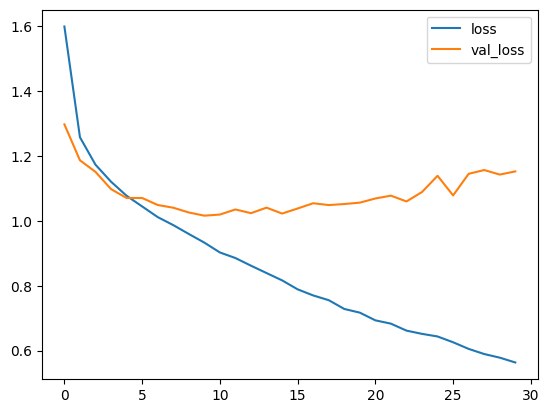

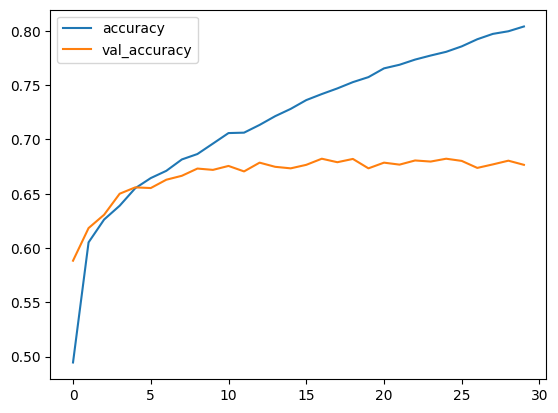

In [8]:
# _, accuracy = CNN.evaluate(x_valid, y_valid, verbose=0)
# print(accuracy)
metrics_df = pd.DataFrame(training.history)
metrics_df[["loss","val_loss"]].plot()
metrics_df[["accuracy", "val_accuracy"]].plot()

In [9]:
_, accuracy_test = CNN.evaluate(x_test, y_test, verbose=0)
print(accuracy_test)

0.6786290407180786


In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

ypred = CNN.predict(x_test)
y_pred = (ypred > 0.5)
y = y_test.values
y = (y > 0.5)

155/155 [==============================] - 2s 13ms/step

In [11]:
print('Accuracy score : ', accuracy_score(y, y_pred))
print('Precision score : ', precision_score(y, y_pred, average='weighted'))
print('Recall score : ', recall_score(y, y_pred, average='weighted'))
print('F1 score : ', f1_score(y, y_pred, average='weighted'))
print(classification_report(y_test, y_pred))

Accuracy score :  0.6286290322580645
Precision score :  0.7196695771855788
Recall score :  0.6286290322580645
F1 score :  0.6614945507882549
              precision    recall  f1-score   support

           0       0.42      0.13      0.20       208
           1       0.78      0.81      0.79      1454
           2       0.71      0.59      0.65      1073
           3       0.61      0.61      0.61       299
           4       0.62      0.19      0.29        42
           5       0.75      0.62      0.67       946
           6       0.72      0.33      0.45        40
           7       0.74      0.41      0.52       123
           8       0.33      0.06      0.11        16
           9       1.00      0.08      0.14        13
          10       0.71      0.21      0.32        24
          11       0.88      0.79      0.83       125
          12       0.95      0.98      0.96        55
          13       0.55      0.27      0.36       224
          14       0.00      0.00      0.00     

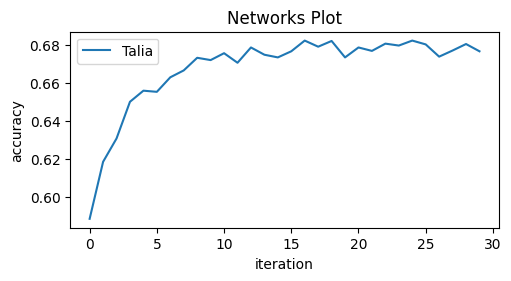

In [13]:
x = np.linspace(0, 2, 100)  # Sample data.

# Note that even in the OO-style, we use `.pyplot.figure` to create the Figure.
fig, ax = plt.subplots(figsize=(5, 2.7), layout='constrained')
ax.plot(range(30), metrics_df["val_accuracy"], label='Talia')
# ax.plot(range(30), metrics_df["val_accuracy"], label='Lior')
# ax.plot(range(30), metrics_df["val_accuracy"], label='Netanel')
ax.set_xlabel('iteration')  # Add an x-label to the axes.
ax.set_ylabel('accuracy')  # Add a y-label to the axes.
ax.set_title("Networks Plot")  # Add a title to the axes.
ax.legend();

In [14]:
from keras.utils import plot_model

n_features, n_outputs = x_train.shape[1], y_train.shape[1]
CNN = models.Sequential()
CNN.add(layers.Conv1D(filters=128, kernel_size=3, activation='relu',
                      input_shape=(n_features, 1), padding='same'))
CNN.add(layers.MaxPooling1D(pool_size=2))
CNN.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
CNN.add(layers.MaxPooling1D(pool_size=2))
CNN.add(layers.Conv1D(filters=128, kernel_size=3, activation='relu'))
CNN.add(layers.MaxPooling1D(pool_size=2))
CNN.add(layers.Dropout(0.6))  #0.6
CNN.add(layers.Flatten())
CNN.add(layers.Dense(128, activation='relu'))
CNN.add(layers.Dense(64, activation='relu'))
CNN.add(layers.Dense(32, activation='relu'))
CNN.add(layers.Dense(16,activation='softmax'))

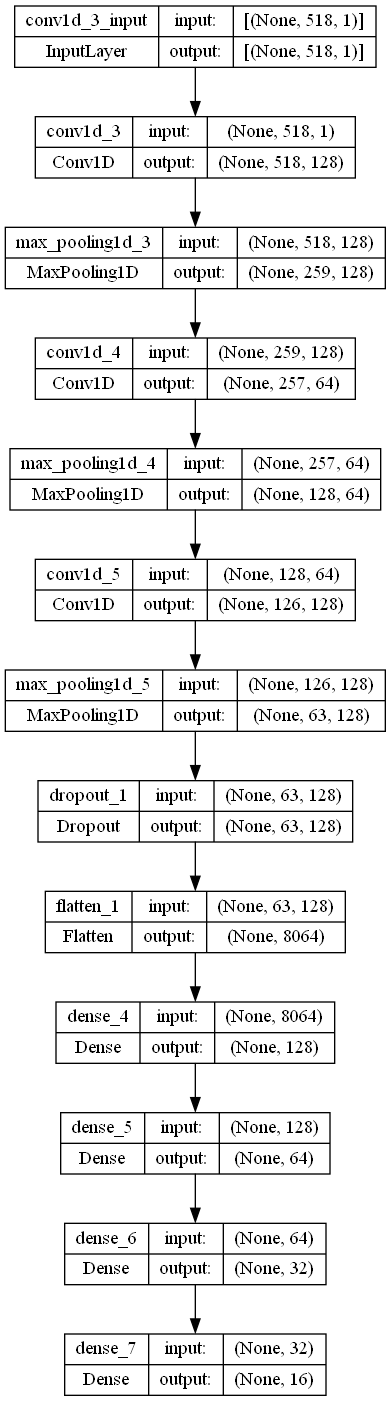

In [15]:
from IPython.display import Image
plot_model(CNN, to_file='model.png', show_shapes=True)
Image("model.png")